# Generate bbox crops from ground truth

In [1]:
from fastai.vision.all import *

Download the dataset from https://www.mapillary.com/dataset/trafficsign (unfortunatelly manually – you need to provide your name and accept the license) and unpack them somewhere (see `path` below).

We will need these files:
- mtsd_fully_annotated_annotation.zip
- mtsd_fully_annotated_images.test.zip
- mtsd_fully_annotated_images.train.0.zip
- mtsd_fully_annotated_images.train.1.zip
- mtsd_fully_annotated_images.train.2.zip
- mtsd_fully_annotated_images.val.zip

In [2]:
# Mapillary dataset path:
path = Path('..')
# Where to put the cropped traffic signs (in separate subfolders for each label):
outpath = Path('yolo-bbox-crops-aspects-carla')

Let's do a quick sanity check on the unpacked data:

In [3]:
# if not (path/'carla-object-detection-dataset/traffic_signs_cleaned/labels/002111.txt').exists():
    # raise IOError(f"Missing annotations, please unpack them to: {path.absolute()}")
if not (path/'KITTI/training/label_2/000000.txt').exists():
    raise IOError(f"Missing annotations, please unpack them to: {path.absolute()}")

In [4]:
# if not (path/'carla-object-detection-dataset/traffic_signs_cleaned/images/002111.jpg').exists():
#     raise IOError(f"Missing images, please unpack them to: {path.absolute()}")
if not (path/'KITTI/training/image_2/000000.jpg').exists():
    raise IOError(f"Missing images, please unpack them to: {path.absolute()}")

In [9]:
# with open(path/'KITTI/training/label_2/', 'r') as f:
#     trnidx = [x.strip().split('/')[-1].split('.')[0] for x in f.readlines()]
# with open(path/'carla-object-detection-dataset/traffic_signs_cleaned/autosplit_val.txt', 'r') as f:
#     validx = [x.strip().split('/')[-1].split('.')[0] for x in f.readlines()]
trnidx = [str(i).zfill(6) for i in range(5000)]

In [10]:
trnidx[0]

'000000'

In [11]:
# label_names = ['Speed-Limit-30', 'Speed-Limit-30-US', 'Speed-Limit-40', 'Speed-Limit-60',
#           'Speed-Limit-60-US', 'Speed-Limit-90', 'Speed-Limit-90-US', 'Stop', 'Interchange',
#           'NoTurnsLeft', 'No-Turns', 'One-Way', 'One-Way-Left', 'Michigan-Left',
#           'Lane-Reduce-Left', 'One-Way-Right','Yield', 'AnimalCrossing']
label_names = ['Car', 'Cyclist', 'Pedestrian']

## Loading the bounding box annotations

In [15]:
def read_mapillary_annotation(idx, width=1224, height=370):
    with open(Path('../KITTI/training/label_2/')/(idx+'.txt')) as fd:
        lines = fd.readlines()
#     w,h = float(anno['width']), float(anno['height'])
        
    labels = []
    bboxes = []
    for line in lines:
        split_line = line.split(' ')
                
        labels.append(split_line[0])
        x1 = float(split_line[4])
        y1 = float(split_line[5])
        x2 = float(split_line[6])
        y2 = float(split_line[7])
        bboxes.append([x1, y1, x2, y2])
    return dict(
        idx = idx, w = width, h = height, pano = False,
        labels = np.array(labels),
        bboxes = np.array(bboxes),
    )

In [16]:
read_mapillary_annotation(trnidx[0])

{'idx': '000000',
 'w': 1224,
 'h': 370,
 'pano': False,
 'labels': array(['Car', 'Cyclist', 'Pedestrian'], dtype='<U10'),
 'bboxes': array([[614., 186., 640., 202.],
        [142., 193., 197., 225.],
        [512., 180., 518., 202.]])}

Calculating width and height – we'll need it to get the aspect ratio of each sign. We are resizing (squishing) every sign into a 40x40 pixels square so remembering the original aspect ratio might be helpful.

In [17]:
bboxes = read_mapillary_annotation(trnidx[0])['bboxes']

In [18]:
wh = bboxes[:,2:] - bboxes[:,:2]
wh

array([[26., 16.],
       [55., 32.],
       [ 6., 22.]])

In [23]:
def create_crops(annotation, output_size=(40,40)):
    aspects = {}
    img = Image.open(f"../KITTI/training/image_2/{annotation['idx']}.jpg")
    for i, (bbox, label) in enumerate(zip(annotation['bboxes'], annotation['labels'])):
        try:
            wh = bbox[2:] - bbox[:2]
            size = np.exp(np.log(wh).mean(-1))
            !mkdir -p {outpath}/{label}
            name = f"{label}/{annotation['idx']}-{i}.jpg"
            aspects[name] = wh[0]/wh[1]
            img.crop(bbox).resize(output_size).save(f"{outpath}/{name}")
        except:
            print(f"Skipping {annotation['idx']}-{i} / {label}")
    return aspects

First let's verify it works for just a couple of images:

In [24]:
!rm -r {outpath}

rm: cannot remove 'yolo-bbox-crops-aspects-carla': No such file or directory


In [25]:
aspects = {k:v for idx in trnidx[:5] for k,v in create_crops(read_mapillary_annotation(idx)).items()}
aspects

{'Car/000000-0.jpg': 1.625,
 'Cyclist/000000-1.jpg': 1.71875,
 'Pedestrian/000000-2.jpg': 0.2727272727272727,
 'Car/000001-0.jpg': 1.5625,
 'Cyclist/000001-1.jpg': 1.9142857142857144,
 'Pedestrian/000001-2.jpg': 0.22727272727272727,
 'Car/000002-0.jpg': 1.5625,
 'Cyclist/000002-1.jpg': 1.7058823529411764,
 'Pedestrian/000002-2.jpg': 0.22727272727272727,
 'Car/000003-0.jpg': 1.5625,
 'Pedestrian/000003-1.jpg': 0.2727272727272727,
 'Car/000004-0.jpg': 1.5625,
 'Pedestrian/000004-1.jpg': 0.22727272727272727}

In [26]:
!ls -lR {outpath}

yolo-bbox-crops-aspects-carla:
total 12
drwxrwxr-x 2 vineet vineet 4096 Oct 12 07:01 Car
drwxrwxr-x 2 vineet vineet 4096 Oct 12 07:01 Cyclist
drwxrwxr-x 2 vineet vineet 4096 Oct 12 07:01 Pedestrian

yolo-bbox-crops-aspects-carla/Car:
total 20
-rw-rw-r-- 1 vineet vineet 939 Oct 12 07:01 000000-0.jpg
-rw-rw-r-- 1 vineet vineet 923 Oct 12 07:01 000001-0.jpg
-rw-rw-r-- 1 vineet vineet 928 Oct 12 07:01 000002-0.jpg
-rw-rw-r-- 1 vineet vineet 933 Oct 12 07:01 000003-0.jpg
-rw-rw-r-- 1 vineet vineet 936 Oct 12 07:01 000004-0.jpg

yolo-bbox-crops-aspects-carla/Cyclist:
total 12
-rw-rw-r-- 1 vineet vineet  929 Oct 12 07:01 000000-1.jpg
-rw-rw-r-- 1 vineet vineet  994 Oct 12 07:01 000001-1.jpg
-rw-rw-r-- 1 vineet vineet 1173 Oct 12 07:01 000002-1.jpg

yolo-bbox-crops-aspects-carla/Pedestrian:
total 20
-rw-rw-r-- 1 vineet vineet 850 Oct 12 07:01 000000-2.jpg
-rw-rw-r-- 1 vineet vineet 904 Oct 12 07:01 000001-2.jpg
-rw-rw-r-- 1 vineet vineet 886 Oct 12 07:01 000002-2.jpg
-rw-rw-r-- 1 vineet vineet

Car/000000-0.jpg
1.625


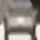

In [27]:
crop = list(aspects.keys())[0]
print(crop)
print(aspects[crop])
Image.open(f"{outpath}/{crop}")

## Generating all the cropped signs (in parallel)

In [28]:
!rm -r {outpath}

In [29]:
def make_crops(idx): return create_crops(read_mapillary_annotation(idx))

In [30]:
trn_aspects = parallel(make_crops, trnidx, progress=True)

In [20]:
# val_aspects = parallel(make_crops, validx, progress=True)

In [ ]:
all_aspects = {k:v for d in trn_aspects for k,v in d.items()}
len(all_aspects)

16702

In [33]:
pd.Series(all_aspects.values()).describe()

count    16702.000000
mean         1.567790
std          1.175402
min          0.062500
25%          0.318182
50%          1.418486
75%          2.586207
max          5.812081
dtype: float64

<AxesSubplot:>

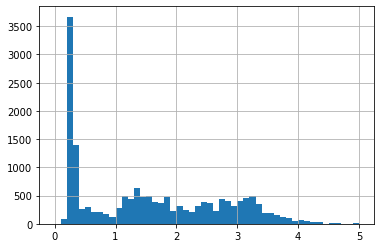

In [34]:
pd.Series(all_aspects.values()).hist(range=(0,5), bins=50)

In [35]:
pd.Series(all_aspects).to_csv('aspect-ratios.csv')